## Data Preprocess

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from deepsramp import *

In [2]:
%%time
gtf = read_gtf('data/Homo_sapiens.GRCh37.87.gtf.gz')
seqs = read_seq('data/Homo_sapiens.GRCh37.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:29: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
51696870it [02:25, 356522.98it/s]

CPU times: user 1min 38s, sys: 1min 22s, total: 3min 1s
Wall time: 3min 3s


In [3]:
%%time
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_mature_cds(gtf, sdf, grp=['id', 'trans'])

CPU times: user 14.7 s, sys: 852 ms, total: 15.6 s
Wall time: 15.6 s


In [4]:
# used for random 
# import random

# def read_m6a_bed(file, name, ndf, pat, get_pos):
#     m6adf = pd.read_csv(file, sep='\t', header=None)
#     m6adf = m6adf[m6adf[0].apply(len) < 6]
#     m6adf[0] = m6adf[0].str.slice(3).replace({'M': 'MT'})
#     tqdm.pandas(desc=name)
#     m6adf['pos'] = m6adf.progress_apply(lambda x: [
#         [
#             gene, 
#             trans, 
#             (lambda y: y if y != -1 and len(re.findall(pat, i.seq[y-2:y+3])) else -1)(get_pos(x[1], i)),
#             # i.length # for max length
#         ] for (gene, trans), i in get_trans(x[0], x[5], x[1], ndf).iterrows()
#     ], axis=1)
#     m6adf['pos'] = m6adf.pos.apply(lambda x: [i for i in x if i[2] != -1]) # drop -1
#     # m6adf['pos'] = m6adf.pos.apply(lambda x: [max(x, key=lambda y: y[3])[:3]] if x else []) # keep max length
#     m6adf['pos'] = m6adf.pos.apply(lambda x: [random.choice(x)] if x else []) # random
#     res = pd.DataFrame(sum(m6adf.pos, []), columns=ndf.index.names+[name])
#     res = res[res[name] != -1]
#     res = res.groupby(ndf.index.names).agg(lambda x: set(x))
#     return res

In [27]:
%%time
files = ['data/GSE/GSE63753/GSE63753_hek293.abcam.CIMS.m6A.9536.bed',
         'data/GSE/GSE63753/GSE63753_hek293.sysy.CITS.m6A.12051.bed',
         'data/GSE/GSE71154/GSM1828594_precise_m6A_sites_CD8T_hg19.bed',
         'data/GSE/GSE71154/GSM1828596_precise_m6A_sites_A549_hg19.bed',
         'data/GSE/GSE98623/GSM2602070_molm13_rep1.tag.uniq.sites.bed.gz',
         'data/GSE/GSE98623/GSM2602071_molm13_rep2.tag.uniq.sites.bed.gz',
         'data/GSE/GSE98623/GSM2602072_molm13_rep3.tag.uniq.sites.bed.gz',
         'data/GSE/GSE86336/GSM2300426_precise_m6A_sites_HeLa_CA_hg19.bed.gz',
         'data/GSE/GSE86336/GSM2300427_precise_m6A_sites_HeLa_NU_hg19.bed.gz',
         'data/GSE/GSE86336/GSM2300428_precise_m6A_sites_HeLa_CY_hg19.bed.gz',
         'data/GSE/GSE86336/GSM2300429_precise_m6A_sites_HeLa_CYpolyA_hg19.bed.gz',
        ]
names = ['abcam', 'sysy', 'cd8t', 'a549', 'molm1', 'molm2', 'molm3', 'hela1', 'hela2', 'hela3', 'hela4']

res = read_m6a_beds(files, names, ndf, RRACH_PAT, get_mature_pos)
res = res.dropna(subset=['m6a_pos'])

hela3: 100%|██████████| 46350/46350 [04:11<00:00, 184.64it/s]


CPU times: user 9 s, sys: 9.35 s, total: 18.4 s
Wall time: 4min 32s


In [5]:
utils.save(res, 'data/GSE/mature_rrach.data')

In [28]:
utils.save(res, 'data/GSE/mature_rrach_random.data')

### YTHDF

In [9]:
%%time
gtf38 = read_gtf('data/Homo_sapiens.GRCh38.79.gtf.gz')
seqs38 = read_seq('data/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:28: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
51662809it [02:17, 376715.85it/s]

CPU times: user 1min 39s, sys: 1min 18s, total: 2min 57s
Wall time: 2min 54s


In [10]:
%%time
sdf38 = get_mature_splice(gtf38, seqs38, grp=['id', 'trans'], keepmax=False, biotype=None)
ndf38 = get_mature_cds(gtf38, sdf38, grp=['id', 'trans'])

CPU times: user 30 s, sys: 2.56 s, total: 32.5 s
Wall time: 32.5 s


In [62]:
yth = pd.read_csv('data/sramp1/YTHDF_mature.csv', usecols=[0,1,2])
yth['Position'] -= 1

ythpos = yth[yth.Class == 1].groupby('TranscriptID').agg({'Position': set})
ythpos.columns = ['ythdf_test']
ythneg = yth[yth.Class == -1].groupby('TranscriptID').agg({'Position': set})
ythneg.columns = ['ythdf_test_neg']
ythdf = ythpos.merge(ythneg, left_index=True, right_index=True, how='outer')

ythdf['ythdf_test'] = ythdf['ythdf_test'].apply(lambda x: utils.notnaor(x, set()))
ythdf['ythdf_test_neg'] = ythdf['ythdf_test_neg'].apply(lambda x: utils.notnaor(x, set()))

ythdf = ythdf.merge(ndf38.reset_index(), left_index=True, right_on='trans').reset_index().set_index('trans')
utils.save(ythdf, 'data/GSE/compare_mature_ythdf_test.data')

In [50]:
# df = utils.load('compare_mature.data')
# df['ythdf_train'] = df['m6a_pos'].copy()
# df['_train_len'] = (df['ythdf_train'].apply(len) * 1).apply(round)
# df['ythdf_train_neg'] = df.apply(lambda x: set(random.choices(list(x.m6a_neg), k=x._train_len)) if len(x.m6a_neg) else set(), axis=1)
# # df = df.merge(ythdf, left_index=True, right_index=True)
# utils.save(df, 'data/GSE/compare_mature.data')

## Sample Negtive Samples

In [6]:
import random

def get_m6a_neg_ratio4(osdf, label='m6a_pos', train_ratio=1, test_ratio=10, pat=RRACH_PAT):
    sdf = osdf
    
    train_label = f'{label}_train'
    test_label = f'{label}_test'
    
    sdf['_train_len'] = (sdf[train_label].apply(len) * train_ratio).apply(round)
    sdf['_test_len'] = (sdf[test_label].apply(len) * test_ratio).apply(round)
    
    sdf['_neg'] = sdf.apply(lambda x: (random.choices(list(x.m6a_neg), k=x._train_len + x._test_len)) if len(x.m6a_neg) else [], axis=1)
    
    sdf[f'{label}_train_neg'] = sdf.apply(lambda x: set(x._neg[x._test_len:]), axis=1)
    sdf[f'{label}_test_neg'] = sdf.apply(lambda x: set(x._neg[:x._test_len]) - x[f'{label}_train_neg'], axis=1)
    
    return sdf

def get_m6a_pos(sdf, test_label='m6a_pos'):
    if test_label != 'm6a_pos':
        pos = sdf.apply(lambda x: set(sum([list(utils.notnaor(x[i], [])) for i in datasets if i != test_label], [])), axis=1)
        sdf[f'{test_label}_train'] = pos
        sdf[f'{test_label}_test'] = sdf.apply(lambda x: utils.notnaor(x[test_label], set()) - x[f'{test_label}_train'], axis=1)
    else:
        pos = sdf.apply(lambda x: set(sum([list(utils.notnaor(x[i], [])) for i in datasets if i != test_label], [])), axis=1)
        sdf['m6a_pos'] = pos
        
    return sdf

In [9]:
datasets = ['a549', 'cd8t', 'hela', 'sysy', 'abcam', 'molm', 'ythdf'][:-1]

res = utils.load('data/GSE/mature_rrach.data')
df = res.reset_index().set_index('trans')
df['molm'] = df.apply(lambda x: set().union(*[i for i in [x.molm1, x.molm2, x.molm3] if i == i]), axis=1)
df['hela'] = df.apply(lambda x: set().union(*[i for i in [x.hela1, x.hela2, x.hela3, x.hela4] if i == i]), axis=1)
df = get_m6a_pos(df) # all pos -> m6a_pos
df = get_m6a_neg(df, pat=RRACH_PAT) # all RRACH -> m6a_neg

for i in tqdm(datasets):
    df = get_m6a_pos(df, test_label=i) # not-i_pos -> i_train; i_pos - m6a_pos -> i_test
    df = get_m6a_neg_ratio4(df, label=i, test_ratio=10, train_ratio=1) # m6a_neg * ratio -> i_test_neg, i_train_neg

# for YTHDF
df['ythdf_train'] = df['m6a_pos'].copy()
df['_train_len'] = (df['ythdf_train'].apply(len) * 1).apply(round)
df['ythdf_train_neg'] = df.apply(lambda x: set(random.choices(list(x.m6a_neg), k=x._train_len)) if len(x.m6a_neg) else set(), axis=1)
# df = df.merge(ythdf, left_index=True, right_index=True)

utils.save(df, 'data/GSE/compare_mature.data')


100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


In [29]:
# used for random
# datasets = ['a549', 'cd8t', 'hela', 'sysy', 'abcam', 'molm', 'ythdf'][:-1]

# res = utils.load('data/GSE/mature_rrach_random.data')
# df = res.reset_index().set_index('trans')
# df['molm'] = df.apply(lambda x: set().union(*[i for i in [x.molm1, x.molm2, x.molm3] if i == i]), axis=1)
# df['hela'] = df.apply(lambda x: set().union(*[i for i in [x.hela1, x.hela2, x.hela3, x.hela4] if i == i]), axis=1)
# df = get_m6a_pos(df) # all pos -> m6a_pos
# df = get_m6a_neg(df, pat=RRACH_PAT) # all RRACH -> m6a_neg

# for i in tqdm(datasets):
#     df = get_m6a_pos(df, test_label=i) # not-i_pos -> i_train; i_pos - m6a_pos -> i_test
#     df = get_m6a_neg_ratio4(df, label=i, test_ratio=10, train_ratio=1) # m6a_neg * ratio -> i_test_neg, i_train_neg

# # for YTHDF
# df['ythdf_train'] = df['m6a_pos'].copy()
# df['_train_len'] = (df['ythdf_train'].apply(len) * 1).apply(round)
# df['ythdf_train_neg'] = df.apply(lambda x: set(random.choices(list(x.m6a_neg), k=x._train_len)) if len(x.m6a_neg) else set(), axis=1)
# # df = df.merge(ythdf, left_index=True, right_index=True)

# utils.save(df, 'data/GSE/compare_mature_random.data')


100%|██████████| 6/6 [00:04<00:00,  1.22it/s]


## Train Single-deepSRAMP and DeepPromise

In [5]:
df = utils.load('data/GSE/compare_mature.data')
ythdf = utils.load('data/GSE/compare_mature_ythdf_test.data')
datasets = ['abcam', 'sysy', 'cd8t', 'a549', 'molm', 'hela', 'ythdf']

In [30]:
df = utils.load('data/GSE/compare_mature_random.data')
ythdf = utils.load('data/GSE/compare_mature_ythdf_test.data')
datasets = ['abcam', 'sysy', 'cd8t', 'a549', 'molm', 'hela', 'ythdf']

In [31]:
for i in (datasets[:-1]):
    print(i,
          df[f'{i}_train'].apply(len).sum(),
          df[f'{i}_train_neg'].apply(len).sum(),
          df[f'{i}_test'].apply(len).sum(),
          df[f'{i}_test_neg'].apply(len).sum(),
    )

print('ythdf',
     df[f'ythdf_train'].apply(len).sum(),
     df[f'ythdf_train_neg'].apply(len).sum(),
     ythdf[f'ythdf_test'].apply(len).sum(),
     ythdf[f'ythdf_test_neg'].apply(len).sum(),
)

abcam 50345 45579 2564 18090
sysy 51203 46313 1706 12671
cd8t 48302 43578 4607 31548
a549 47915 43241 4994 35462
molm 48670 44050 4239 29347
hela 36747 34112 16162 95244
ythdf 52909 47781 5318 53180


In [42]:
for i in (datasets[:-1]):
    rtrain = df[f'{i}_train'].apply(len).sum() / df[f'{i}_train_neg'].apply(len).sum()
    rtest = df[f'{i}_test'].apply(len).sum() / df[f'{i}_test_neg'].apply(len).sum()
    overlap_pos = df.apply(lambda x: len(x[f'{i}_train'] & x[f'{i}_test']), axis=1).sum()
    overlap_neg = df.apply(lambda x: len(x[f'{i}_train_neg'] & x[f'{i}_test_neg']), axis=1).sum()
    overlap_pn = df.apply(lambda x: len(x[f'{i}_train'] & x[f'{i}_train_neg']), axis=1).sum()
    overlap_tpn = df.apply(lambda x: len(x[f'{i}_test'] & x[f'{i}_test_neg']), axis=1).sum()
    print(i, rtrain, rtest, overlap_pos, overlap_neg, overlap_pn, overlap_tpn, sep='\t')

abcam	1.1062890041311417	0.14152453496715792	0	0	0	0
sysy	1.1059441012570737	0.13531091370558376	0	0	0	0
cd8t	1.1069807947930512	0.14642596065219465	0	0	0	0
a549	1.106863175402527	0.13993891332978395	0	0	0	0
molm	1.1062620752358223	0.14457708049113233	0	0	0	0
hela	1.0773087071240106	0.16963704683334382	0	0	0	0


In [ ]:
test_res = []
for name in datasets:
    i = name
    print(f'Generating test data - [{name}]')
    if name == 'ythdf':
        testds = df2ds(ythdf, downsample=False, pos_label=f'{i}_test', neg_label=f'{i}_test_neg')
    else:
        testds = df2ds(df, downsample=False, pos_label=f'{i}_test', neg_label=f'{i}_test_neg')
    testdl = ds2dl(testds, drop_last=False, num_workers=0)

    print(f'Generating train data - [{name}]')
    trainds = df2ds(df, downsample=False, pos_label=f'{i}_train', neg_label=f'{i}_train_neg')
    traindl = ds2dl(trainds, drop_last=True, num_workers=8)
    
    print(f'Building model - [{name}]')
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SRAMP().to(device)
    loss_fn = TriLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1, 2)

    print(f'Start to train - [{name}]')
    train(model, loss_fn, optimizer, scheduler, traindl, testdl, epochs=1, device=device)
    test_res += [test_loop(testdl, model, device, loss_fn)]

    dps = []
    for i in ['onehot', 'enac', 'embedding', 'ensemble']:
        print(i)
        traindl = ds2dl(trainds, drop_last=True, num_workers=8)
        if i == 'ensemble':
            dp = DeepPromiseEnsemble(*dps).to(device)
        else:
            dp = DeepPromise(i).to(device)
        loss_fn = DPLoss()
        optimizer = torch.optim.Adam(dp.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1, 2)
        print(f'Start to train - [{i}]')
        train(dp, loss_fn, optimizer, scheduler, traindl, testdl, epochs=1, device=device)
        test_res += [dp_test_loop(testdl, dp, device, loss_fn)]
        dps += [dp]


In [55]:
torch.save(model, 'model/deepsramp_mature_sramp1data_all.model')

In [56]:
utils.save(test_res, 'model/deepsramp_mature_sramp1data_all.metric')

### WHISTLE

In [78]:
def df2bed(testdf, pos_label, neg_label, name="", mode="mature"):
    if name == "": name = pos_label
    whi_test = []
    for _, i in tqdm(testdf.iterrows(), total=testdf.shape[0], desc=pos_label):
        for j in utils.notnaor(i[pos_label], []):
            genome = get_genome_pos(j, i, mode)
            whi_test += [[f'chr{i[0] if i[0] != "MT" else "M"}', genome, genome+1, i[6], 1]]
        for j in utils.notnaor(i[neg_label], []):
            genome = get_genome_pos(j, i, mode)
            whi_test += [[f'chr{i[0] if i[0] != "MT" else "M"}', genome, genome+1, i[6], 0]]

    pd.DataFrame(whi_test, columns=['#chromsome', 'modStart', 'modEnd', 'strand', 'label']).to_csv(f'whistle/traindata1/{name.replace(' ', '.')}_whistle.bed', sep='\t', index=None, header=None)

In [80]:
for i in datasets:
    if i == 'ythdf':
        df2bed(ythdf, f'{i}_test', f'{i}_test_neg')
    else:
        df2bed(df, f'{i}_test', f'{i}_test_neg')
    df2bed(df, f'{i}_train', f'{i}_train_neg')


ythdf_train: 100%|██████████| 10331/10331 [00:02<00:00, 4107.01it/s]


## Train Multi-deepSRAMP

In [65]:
data_dfs = {}
datasets = ['abcam', 'sysy', 'cd8t', 'a549', 'molm', 'hela', 'ythdf']

def task_transform(name):
    dfs = []
    for train in ['train', 'test']:
        if name == 'ythdf' and train == 'test':
            idf = ythdf
            indf = ndf38
        else:
            idf = df
            indf = ndf
        tdf = []
        exist_grp = set()
        for neg in ['', '_neg']:
            for _, i in tqdm(idf.iterrows(), total=idf.shape[0]):
                for j in i[f'{name}_{train}{neg}']:
                    genome_pos = get_genome_pos(j, i)
                    if i[0] + i[6] + str(genome_pos) in exist_grp: continue
                    else: exist_grp.add(i[0] + i[6] + str(genome_pos))
                    for trans, k in indf.loc[i.id].iterrows():
                        mature_pos = get_mature_pos(genome_pos, k)
                        if mature_pos != -1:
                            tdf += [(i.id, trans, mature_pos, i[0] + i[6] + str(genome_pos), neg)]
        tdf = pd.DataFrame(tdf, columns=['id', 'trans', 'pos', 'grp', 'label'])
        tdf['label'] = (tdf['label'] == '') * 1
        tdf = tdf.merge(indf.reset_index(), left_on=['id', 'trans'], right_on=['id', 'trans'])
        dfs += [tdf]
    return name, dfs

df = utils.load('data/GSE/compare_mature.data')
ythdf = utils.load('data/GSE/compare_mature_ythdf_test.data')
dfs = Parallel(n_jobs=8)(delayed(task_transform)(name) for name in datasets)
data_dfs = dict(dfs)

100%|██████████| 2797/2797 [00:30<00:00, 92.01it/s] 


In [66]:
utils.save(data_dfs, 'data/GSE/compare_mature_multi.data')

In [2]:
data_dfs = utils.load('data/GSE/compare_mature_multi.data')
datasets = ['abcam', 'sysy', 'cd8t', 'a549', 'molm', 'hela', 'ythdf']

In [ ]:
test_res = []
for i in datasets:
    traindf, testdf = data_dfs[i]
    
    trainds = df2ds_multi(traindf)
    traindl = ds2dl(trainds, batch_size=128, drop_last=True, num_workers=4)
    
    testds = df2ds_multi(testdf)
    testdl = ds2dl(testds, batch_size=128, shuffle=False, num_workers=4)
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    utils.setup_seed(42)
    
    model = MultiSRAMP().to(device)
    loss_fn = TriLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1, 2)
    
    print(f'Start to train - [{i}]')
    train(model, loss_fn, optimizer, scheduler, traindl, testdl, epochs=31, device=device)
    test_res += [test_loop(testdl, model, device, loss_fn)]

    torch.save(model, f'model/full_400_{i}.model')
    utils.save(test_res, f'model/full_400_{i}.metrics')

## Performance

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
font_manager.fontManager.addfont('/home/fanrui/fonts/ARIAL.TTF')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

In [3]:
datasets_1 = ['a549', 'cd8t', 'hela', 'abcam', 'sysy', 'molm', 'ythdf']

In [4]:
test_res = []
for i in datasets_1:
    test_res += utils.load(f'model/full_400_{i}.metrics')

data = np.array([[i[-1]['1.0']['precision'], i[-1]['1.0']['recall'], i[-1]['1.0']['f1-score'], i[-1]['0.0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (test_res)])#.shape#.reshape((7, 5, -1))
t = pd.DataFrame(data, columns=['Precision', 'Recall', 'F1', 'Specificity', 'Accuracy', 'MCC', 'AUPRC', 'AUROC'], index=[i for i in datasets_1])
t.index.name = 'MultiSRAMP'
t

,Precision,Recall,F1,Specificity,Accuracy,MCC,AUPRC,AUROC
MultiSRAMP,,,,,,,,
a549,0.573559,0.908690,0.703239,0.905091,0.905535,0.674819,0.823551,0.969817
cd8t,0.549798,0.914261,0.686664,0.889984,0.893095,0.656464,0.784318,0.962912
hela,0.558173,0.875387,0.681683,0.881645,0.880732,0.636167,0.778131,0.953155
abcam,0.658184,0.817083,0.729076,0.939880,0.924641,0.691309,0.848362,0.971667
sysy,0.655909,0.917351,0.764907,0.934826,0.932741,0.740856,0.867039,0.980306
molm,0.586938,0.797122,0.676070,0.918712,0.903323,0.630836,0.784457,0.956643
ythdf,0.506625,0.866997,0.639539,0.916544,0.912087,0.621194,0.745976,0.967138


In [81]:
test_res = []
for i in datasets_1:
    test_res += utils.load(f'model/full_400_{i}_single.metrics')

data = np.array([[i[-1]['1.0']['precision'], i[-1]['1.0']['recall'], i[-1]['1.0']['f1-score'], i[-1]['0.0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (test_res)])#.shape#.reshape((7, 5, -1))
t = pd.DataFrame(data, columns=['Precision', 'Recall', 'F1', 'Specificity', 'Accuracy', 'MCC', 'AUPRC', 'AUROC'], index=[i for i in datasets_1])
t.index.name = 'SRAMP'
t

,Precision,Recall,F1,Specificity,Accuracy,MCC,AUPRC,AUROC
SRAMP,,,,,,,,
a549,0.550586,0.912095,0.686666,0.895816,0.897815,0.658696,0.793165,0.965697
cd8t,0.527489,0.903842,0.666187,0.881448,0.884308,0.633944,0.758831,0.957643
hela,0.559523,0.821247,0.665580,0.890327,0.880308,0.612132,0.724289,0.941825
abcam,0.627424,0.719189,0.670180,0.939560,0.912238,0.621757,0.765890,0.955075
sysy,0.632723,0.870457,0.732791,0.931631,0.924340,0.701916,0.825184,0.972434
molm,0.549229,0.714555,0.621079,0.915211,0.889866,0.564548,0.684066,0.936770
ythdf,0.483259,0.795224,0.601180,0.914968,0.904082,0.572416,0.649307,0.953851


In [82]:
test_res = []
for i in datasets_1:
    test_res += [utils.load(f'model/full_400_{i}_dp.metrics')[-1]]

data = np.array([[i[-1]['1.0']['precision'], i[-1]['1.0']['recall'], i[-1]['1.0']['f1-score'], i[-1]['0.0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (test_res)])#.shape#.reshape((7, 5, -1))
t = pd.DataFrame(data, columns=['Precision', 'Recall', 'F1', 'Specificity', 'Accuracy', 'MCC', 'AUPRC', 'AUROC'], index=[i for i in datasets_1])
t.index.name = 'DP'
t

,Precision,Recall,F1,Specificity,Accuracy,MCC,AUPRC,AUROC
DP,,,,,,,,
a549,0.289983,0.804565,0.426313,0.724325,0.734176,0.366232,0.418955,0.842155
cd8t,0.293629,0.798350,0.429347,0.718781,0.728944,0.362546,0.420442,0.838535
hela,0.313542,0.674050,0.427996,0.749659,0.738693,0.322095,0.390339,0.791095
abcam,0.234441,0.580343,0.333969,0.731799,0.713022,0.223042,0.278911,0.723788
sysy,0.253255,0.684056,0.369655,0.727078,0.721951,0.285115,0.311095,0.785666
molm,0.232547,0.574428,0.331067,0.725921,0.706785,0.215354,0.264470,0.713264
ythdf,0.173946,0.696502,0.278371,0.669237,0.671715,0.218523,0.238700,0.747836


In [5]:
single = utils.load('test_res')
whistle = utils.load('whistle_performance.pk')

In [6]:
multi = np.array([[i[-1]['1.0']['precision'], i[-1]['1.0']['recall'], i[-1]['1.0']['f1-score'], i[-1]['0.0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (test_res)])
data = np.array([[i[-1]['1.0']['precision'], i[-1]['1.0']['recall'], i[-1]['1.0']['f1-score'], i[-1]['0.0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (single)])
wdata = np.array([[i[-1]['1']['precision'], i[-1]['1']['recall'], i[-1]['1']['f1-score'], i[-1]['0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (whistle)])
data = np.concatenate([multi, data, wdata])
t = pd.DataFrame(data, columns=['Precision', 'Recall', 'F1', 'Specificity', 'Accuracy', 'MCC', 'AUPRC', 'AUROC'])
methods = ['deepSRAMP']*7 + [i for j in ['A549', 'CD8T', 'HeLa', 'HEK293 Abcam', 'HEK293 SYSY', 'MOLM13', 'YTHDF'] for i in ['deepSRAMP_Single', 'DP-oh', 'DP-enac', 'DP-emb', 'DeepPromise']] + ['WHISTLE']*7
ds = ['A549', 'CD8T', 'HeLa', 'HEK293 Abcam', 'HEK293 SYSY', 'MOLM13', 'YTHDF'] + [j for j in ['A549', 'CD8T', 'HeLa', 'HEK293 Abcam', 'HEK293 SYSY', 'MOLM13', 'YTHDF'] for i in ['deepSRAMP_Single', 'DP-oh', 'DP-enac', 'DP-emb', 'DeepPromise']] + [j for j in ['A549', 'CD8T', 'HeLa', 'HEK293 Abcam', 'HEK293 SYSY', 'MOLM13', 'YTHDF']]
t['method'] = methods
t['dataset'] = ds
t.to_csv('fig/performance.csv')
t

,Precision,Recall,F1,Specificity,Accuracy,MCC,AUPRC,AUROC,method,dataset
0,0.573559,0.908690,0.703239,0.905091,0.905535,0.674819,0.823551,0.969817,deepSRAMP,A549
1,0.549798,0.914261,0.686664,0.889984,0.893095,0.656464,0.784318,0.962912,deepSRAMP,CD8T
2,0.558173,0.875387,0.681683,0.881645,0.880732,0.636167,0.778131,0.953155,deepSRAMP,HeLa
3,0.658184,0.817083,0.729076,0.939880,0.924641,0.691309,0.848362,0.971667,deepSRAMP,HEK293 Abcam
4,0.655909,0.917351,0.764907,0.934826,0.932741,0.740856,0.867039,0.980306,deepSRAMP,HEK293 SYSY
5,0.586938,0.797122,0.676070,0.918712,0.903323,0.630836,0.784457,0.956643,deepSRAMP,MOLM13
6,0.506625,0.866997,0.639539,0.916544,0.912087,0.621194,0.745976,0.967138,deepSRAMP,YTHDF
7,0.546170,0.916700,0.684510,0.893407,0.896266,0.657284,0.809242,0.967068,deepSRAMP_Single,A549
8,0.281342,0.807970,0.417356,0.711183,0.723065,0.356591,0.408472,0.836564,DP-oh,A549
9,0.285945,0.813977,0.423217,0.715555,0.727637,0.364457,0.416247,0.839664,DP-enac,A549


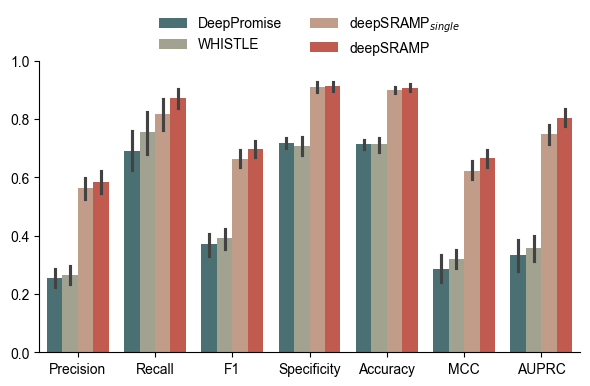

In [10]:
tt = t.set_index(['method', 'dataset']).stack()[['deepSRAMP', 'deepSRAMP_Single', 'WHISTLE', 'DeepPromise']].reset_index()
tt['method'] = tt.method.replace({'deepSRAMP_Single': 'deepSRAMP$_{{single}}$'})
tt = tt[tt.level_2 !='AUROC']

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.barplot(data=tt, x='level_2', y=0, hue='method', hue_order=['DeepPromise', 'WHISTLE', 'deepSRAMP$_{{single}}$', 'deepSRAMP'], palette=['#44757A', '#A5A58D', '#CB997E', '#D44C3C'])
plt.legend(loc='upper center', frameon=False, ncol=2, bbox_to_anchor=(0.5, 1.2))
plt.ylim((0, 1))
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('fig/fig2_allmetric.svg')
plt.show()

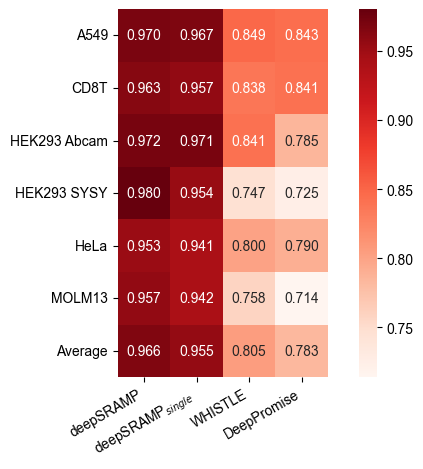

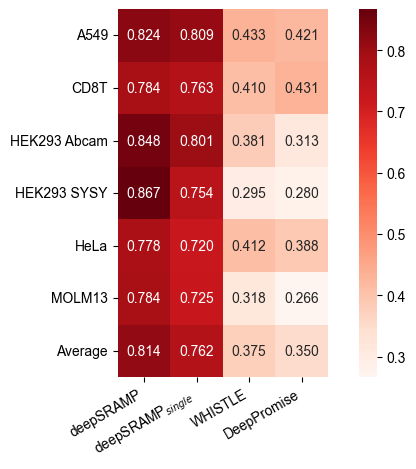

In [11]:
for i in ['AUROC', 'AUPRC']:
    tt = t[t.dataset != 'YTHDF'][[i, 'method', 'dataset']].set_index(['method', 'dataset']).unstack()[i]
    tt = tt.loc[['deepSRAMP', 'deepSRAMP_Single', 'WHISTLE', 'DeepPromise']]
    tt.index = ['deepSRAMP', 'deepSRAMP$_{{single}}$', 'WHISTLE', 'DeepPromise']
    tt['Average'] = tt.mean(axis=1)
    sns.heatmap(tt.T, cmap='Reds', annot=True, fmt='.3f', square=True)
    plt.xticks(rotation=30, horizontalalignment='right', verticalalignment='top')
    plt.yticks(rotation=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig(f'fig/fig2_{i}.svg')
    plt.show()

In [12]:
colors = ['#44757A', '#A5A58D', '#CB997E', '#D44C3C']

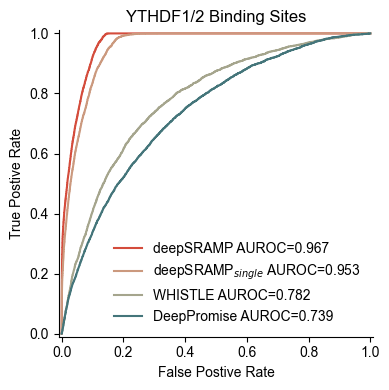

In [13]:
# roc
rocs = [[test_res[-1][3], test_res[-1][4]]] + [[i[3], i[4]] for i in single[-5:]] + [[whistle[-1][3], whistle[-1][4]]]
aucs = [test_res[-1][1]] + [i[1] for i in single[-5:]] + [whistle[-1][1]]

fig = plt.figure(figsize=(4, 4))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# sns.lineplot(x=rocs[0][0], y=rocs[0][1], label='SRAMP2')
plt.plot(*rocs[0], label=f'deepSRAMP AUROC={aucs[0]:.3f}', color=colors[3])
plt.plot(*rocs[1], label=f'deepSRAMP$_{{single}}$ AUROC={aucs[1]:.3f}', color=colors[2])
plt.plot(*rocs[6], label=f'WHISTLE AUROC={aucs[6]:.3f}', color=colors[1])
plt.plot(*rocs[5], label=f'DeepPromise AUROC={aucs[5]:.3f}', color=colors[0])
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('YTHDF1/2 Binding Sites')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('fig/fig2_ythdf_roc.svg')
plt.show()

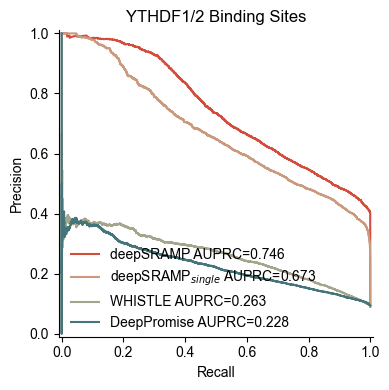

In [14]:
# prc
rocs = [[test_res[-1][7], test_res[-1][6]]] + [(i[7], i[6]) for i in single[-5:]] + [(whistle[-1][7], whistle[-1][6])]
aucs = [test_res[-1][2]] + [i[2] for i in single[-5:]] + [whistle[-1][2]]

fig = plt.figure(figsize=(4, 4))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot(*rocs[0], label=f'deepSRAMP AUPRC={aucs[0]:.3f}', color=colors[3])
plt.plot(*rocs[1], label=f'deepSRAMP$_{{single}}$ AUPRC={aucs[1]:.3f}', color=colors[2])
plt.plot(*rocs[6], label=f'WHISTLE AUPRC={aucs[6]:.3f}', color=colors[1])
plt.plot(*rocs[5], label=f'DeepPromise AUPRC={aucs[5]:.3f}', color=colors[0])
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=(0, -0.02))
plt.title('YTHDF1/2 Binding Sites')
plt.tight_layout()
plt.savefig('fig/fig2_ythdf_prc.svg')
plt.show()

### Random

In [22]:
datasets_1 = ['a549', 'cd8t', 'hela', 'abcam', 'sysy', 'molm', 'ythdf']

In [23]:
ts = []
for a in ['dp', 'single']:
    for b in ['', '_random']:
        test_res = []
        for i in datasets_1:
            test_res += [utils.load(f'model/full_400_{i}_{a}{b}.metrics')[-1]]
        
        data = np.array([[i[-1]['1.0']['precision'], i[-1]['1.0']['recall'], i[-1]['1.0']['f1-score'], i[-1]['0.0']['recall'], i[-1]['accuracy'], i[-2], i[2], i[1]] for i in (test_res)])#.shape#.reshape((7, 5, -1))
        t = pd.DataFrame(data, columns=['Precision', 'Recall', 'F1', 'Specificity', 'Accuracy', 'MCC', 'AUPRC', 'AUROC'], index=[i for i in datasets_1])
        t.loc['average'] = t.iloc[:-1].mean(axis=0)
        ts += [t[['AUPRC', 'AUROC']]]

ts = pd.concat(ts, axis=1).T
ts['method'] = [f'{a}{b}' for a in ['DeepPromise', 'deepSRAMP$_{single}$'] for b in ['_maxlen', '_random'] for _ in range(2)]

In [24]:
ts.reset_index().set_index(['method', 'index']).to_csv('fig/random.csv')

In [25]:
ts

,a549,cd8t,hela,abcam,sysy,molm,ythdf,average,method
AUPRC,0.418955,0.420442,0.390339,0.278911,0.311095,0.264470,0.238700,0.347368,DeepPromise_maxlen
AUROC,0.842155,0.838535,0.791095,0.723788,0.785666,0.713264,0.747836,0.782417,DeepPromise_maxlen
AUPRC,0.425007,0.424914,0.384913,0.272305,0.304974,0.262237,0.237371,0.345725,DeepPromise_random
AUROC,0.843230,0.839872,0.788713,0.720002,0.787811,0.711557,0.746492,0.781864,DeepPromise_random
AUPRC,0.793165,0.758831,0.724289,0.765890,0.825184,0.684066,0.649307,0.758571,deepSRAMP$_{single}$_maxlen
AUROC,0.965697,0.957643,0.941825,0.955075,0.972434,0.936770,0.953851,0.954907,deepSRAMP$_{single}$_maxlen
AUPRC,0.807154,0.736249,0.726165,0.778184,0.789418,0.683276,0.610044,0.753407,deepSRAMP$_{single}$_random
AUROC,0.967206,0.954290,0.941138,0.955560,0.970154,0.936784,0.950582,0.954189,deepSRAMP$_{single}$_random
